### Install required R pacakges

1. First, you need to install the [devtools][] package. You can do this from [CRAN][] by using the following command

 `install.packages("devtools")`

2. Load the devtools package by using the following command

 `library(devtools)`
  
3. Install the latest xmsPANDA package by using the following R command

 `install_github("kuppal2/xmsPANDA")`
 
4. Intall CMA package from [Bioconductor][] by using the following commands

 `if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
  BiocManager::install("CMA", version = "3.8")
 `

   [devtools]: https://github.com/r-lib/devtools
   [CRAN]: https://cran.r-project.org/
   [Bioconductor]: https://www.bioconductor.org/
   

### Load xmsPANDA, CMA and source code

In [1]:
library(xmsPANDA);
library(CMA);
source("https://sourceforge.net/projects/xmsanalyzer/files/xmsPANDA_v1.0.6.71.R");

### Load the Rda file with data matrices

In [2]:
# You need to downlaod the BioBankmetabpanda.Rda file from Precision Medicine Platform workplace first
load(paste(getwd(),'BioBankDiagnostic247.Rda',sep='/'))

### Analysis 1: simple linear regression

In [3]:
lmregres.auc<-new("list")
pval_mat<-c(0.0005,0.005,0.05)

#simple linear regression
options(warn=-1)
lmregres<-runlmreg(X=Xtrain,Y=Ytrain_mat[,2],pvalue.thresh=0.05,fdrmethod="BH")
print(paste("Number of feature selected at FDR<0.05:",length(lmregres$selected.index),sep=""))

pval_names<-c("p<0.0005","p<0.005","p<0.05","FDR<0.05")

for(i in 1:length(pval_mat)){
    #simple linear regression
    lmregres<-runlmreg(X=Xtrain,Y=Ytrain_mat[,2],pvalue.thresh=pval_mat[i],fdrmethod="none")
    
    print(paste("Number of feature selected at ",pval_names[i],":",length(lmregres$selected.index),sep=""))

    
    suppressWarnings(lmregres.auc[[i]]<-get_classification.accuracy(kfold=10,featuretable=Xtrain[lmregres$selected.index,],classlabels=Ytrain_mat[,2],classifier="logitreg",testfeaturetable=Xtest[lmregres$selected.index,],testclasslabels=Ytest_mat[,2],errortype="BAR",kernelname="radial"))
}


Once these R commands are done, it will generate a series of files under the current working folder which include "lmregresults.allfeatures.txt", "lmregresults.selectedfeatures.txt", "ROClogit.rda" and "ROCsvm.rda". To know your current working path, type `getwd()` on R console. 

In [4]:
#Code for generating ROC curves
png("Analysis1_ROC_regression_pvalues.png",width=8,height=8,res=300,type="cairo",units="in");

col_vec<-c("#0072B2", "#E69F00", "#009E73", "gold1", "#56B4E9", "#D55E00", "#CC79A7","gray30")
auc_vec<-{}

for(i in 1:length(lmregres.auc))
{
    stats1a<-performance(lmregres.auc[[i]]$test_res$roc_lr$roc,"tpr","fpr")
    auc_vec<-c(auc_vec,round(lmregres.auc[[i]]$test_res$roc_lr$auc,2))
    
    if(i==1){
        plot(stats1a@x.values[[1]],stats1a@y.values[[1]],col=col_vec[i],type="l",lty=i,lwd=2,xlab="1-specificity",ylab="Sensitivity",main="Receiver Operating Characteristic curve")
        lines(seq(0,1),seq(0,1),lwd=2)
    }else{
        
        lines(stats1a@x.values[[1]],stats1a@y.values[[1]],col=col_vec[i],type="l",lty=i,lwd=2)
    }
    
}

auc_vec<-auc_vec<-c(auc_vec," NA (no features selected)")
legend('bottomright', paste(pval_names,":",auc_vec,sep=""), col=col_vec[1:4], lty=1:4, cex=0.8, bty='n',lwd=rep(2,8))

dev.off()
options(warn=0)


Once these R commands are done, it will generate an image with PNG format called 'Analysis1_ROC_regression_pvalues.png' under the current working folder.

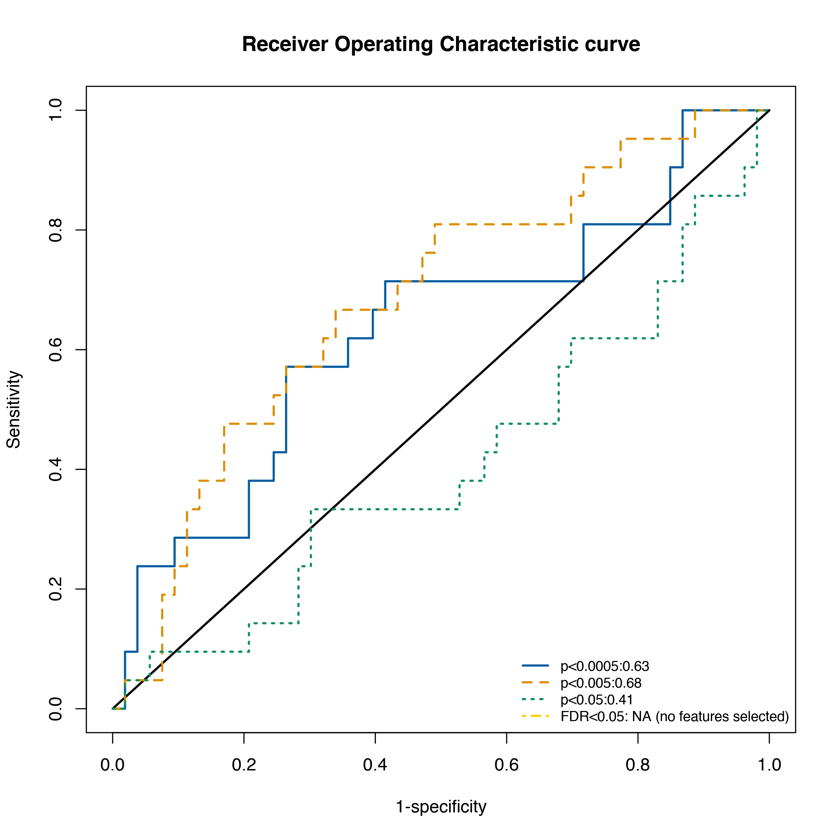

In [5]:
#Read the output image
## load png package for reading an image
library(png)

img <- readPNG('Analysis1_ROC_regression_pvalues.png')
grid::grid.raster(img)

### Analysis 2: using ensemble feature selection

In [6]:
#set output folder name
output="CVDensemble/"


res_ensemble<-diffexp.biomarkers(X=Xtrain,Y=Ytrain_mat,outloc=output,Xtest=Xtest,Ytest=Ytest_mat)

suppressWarnings(logitreg.auc<-get_classification.accuracy(kfold=10,featuretable=res_ensemble$train.selected.data,classlabels=Ytrain_mat[,2],classifier="logitreg",testfeaturetable=res_ensemble$test.selected.data,testclasslabels=Ytest_mat[,2],errortype="BAR",kernelname="radial"))


Once these R commands are done, it will generate a folder called "CVDensemble" under the current working folder. To know your current working path, type `getwd()` on R console. 

In [7]:
#Code for generating ROC curves
png("Analysis2_ROC_classifier_comparison.png",width=8,height=8,res=300,type="cairo",units="in")

col_vec<-c("#0072B2", "#E69F00", "#009E73", "gold1", "#56B4E9", "#D55E00", "#CC79A7","gray30")
auc_vec<-{}
classifier_names<-c("PLSLDA","PLSRF","SCDA","SVM","RF","NNet","pLR","LR(ensemble)")

result_cma_list=res_ensemble$test.result.classifiers

for(i in 1:length(result_cma_list))
{
    
    object=result_cma_list[[i]]
    roc1<-ROCinternal.panda(test = object@prob[,2], object@y,FALSE)
    auc_vec<-c(auc_vec,round(roc1$auc,2))
    roc1=roc1$plotcoordinates
    if(i==1){
        plot(roc1$x,roc1$y,col=col_vec[i],type="s",lty=i,lwd=2,xlab="1-specificity",ylab="Sensitivity",main="Receiver Operating Characteristic curve")
        lines(seq(0,1),seq(0,1),lwd=2)
    }else{
        
        lines(roc1$x,roc1$y,col=col_vec[i],type="s",lty=i,lwd=2)
    }
    
}

roc_1<-performance(logitreg.auc$test_res$roc_lr$roc,"tpr","fpr")
p1<-performance(logitreg.auc$test_res$roc_lr$roc,"auc")
auc_vec<-c(auc_vec,round(p1@y.values[[1]],2))
lines(roc1$x,roc1$y,col=col_vec[8],type="s",lty=i,lwd=2)
legend('bottomright', paste(classifier_names,":",auc_vec,sep=""), col=col_vec[1:8], lty=1:8, cex=0.8, bty='n',lwd=rep(2,8))

dev.off()

Once these R commands are done, it will generate an image with PNG format called 'Analysis2_ROC_classifier_comparison.png' under the current working folder.

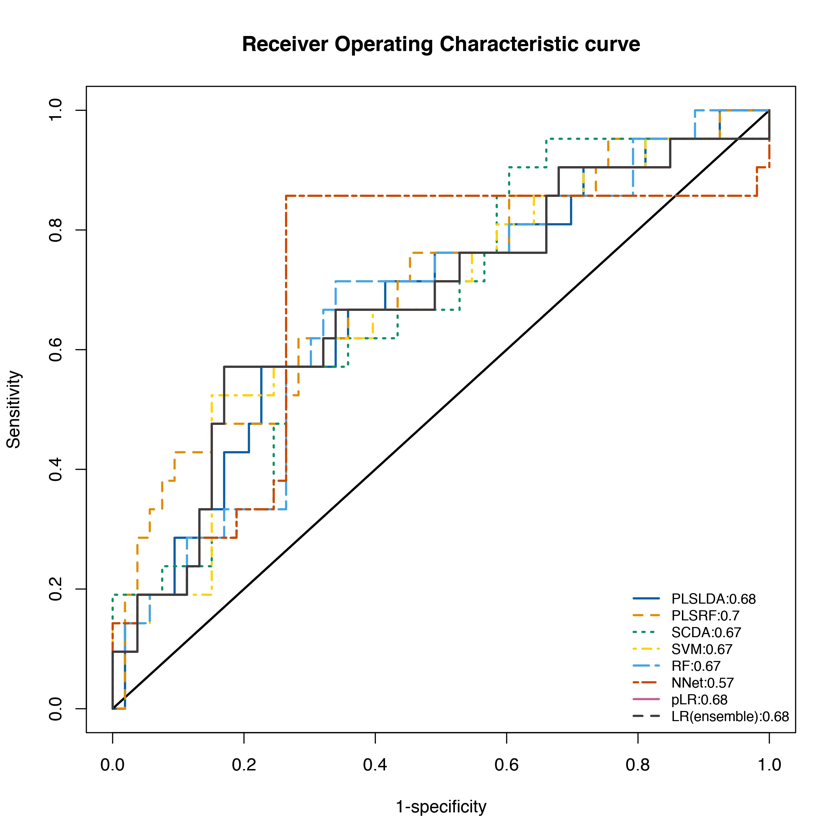

In [8]:
#Read the output image
## load png package for reading an image
library(png)

img <- readPNG('Analysis2_ROC_classifier_comparison.png')
grid::grid.raster(img)